# Streaming Training Tweets Using Tweepy

[Tweepy](https://www.tweepy.org) is a python wrapper for the [Twitter API](https://developer.twitter.com/en/docs) that allowed our team to easily collect tweets in real-time and store them in [MongoBD](https://www.mongodb.com). The below script was run on macOS with 6 GiB of storage for roughly 10 hours. By filtering based on location, I only received geotagged tweets with a known location to use for training the model. I didn't retrieve data from oceania countries because there is a error called 406 when I run my code. You can fine the bounding boxes of each country [here.](https://gist.github.com/graydon/11198540). After collecting data from the golbal, we found that the dataset among 10 countries are extreme inbalance. Therefore, we are going to collect more records from the least 8 countries.

In [32]:
import tweepy
import json
from pymongo import MongoClient

class StreamListener(tweepy.StreamListener):
    """tweepy.StreamListener is a class provided by tweepy used to access
    the Twitter Streaming API to collect tweets in real-time.
    """

    def on_connect(self):
        """Called when the connection is made"""
        
        print("You're connected to the streaming server.")

    def on_error(self, status_code):
        """This is called when an error occurs"""
        
        print('Error: ' + repr(status_code))
        return False

    def on_data(self, data):
        """This will be called each time we receive stream data"""
        
        client = MongoClient()

        # I stored the tweet data in a database called 'training_tweets' in MongoDB, if 
        # 'training_tweets' does not exist it will be created for you.
        db = client.training_tweets

        # Decode JSON
        datajson = json.loads(data)

        # I'm only storing tweets in English. I stored the data for these tweets in a collection 
        # called 'training_tweets_collection' of the 'training_tweets' database. If 
        # 'training_tweets_collection' does not exist it will be created for you. 
        if "lang" in datajson:
            db.training_tweets_collection.insert_one(datajson)


if __name__ == "__main__":

    # These are provided to you through the Twitter API after you create a account
    consumer_key = "owL3x8WeEke0BCHCQHUvEykKv"
    consumer_secret = "gam4Ha8K2UOOgisXxSIU35vAnmNR0DXDm2ILtnOJsROOIOPyVY"
    access_token = "1225979021344878594-B2jw0KZO5xDddPV5Vn8sQOuOvfCzwc"
    access_token_secret = "Ir0Lg9rwBzFTZd0Zy62Lb3sE14SrrjYdIKBeqoNB5OXUt"

    auth1 = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth1.set_access_token(access_token, access_token_secret)

    # LOCATIONS are the longitude, latitude coordinate corners for a box that restricts the 
    # geographic area from which you will stream tweets. The first two define the southwest
    # corner of the box and the second two define the northeast corner of the box. 
    #LOCATIONS = [-180,-90,180,90]        # read all the stream around the world  
    LOCATIONS = [#129.408463169, 31.0295791692, 145.543137242, 45.5514834662,        # japan
                #-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085,         # UK
                95.2930261576, -10.3599874813, 141.03385176, 5.47982086834,         # Indonesia
                26.0433512713, 35.8215347357, 44.7939896991, 42.1414848903,         # Turkey
                #68.1766451354, 7.96553477623, 97.4025614766, 35.4940095078,         # India
                -73.4154357571, -55.25, -53.628348965, -21.8323104794,              # Argentina
                -117.12776, 14.5388286402, -86.811982388, 32.72083,                 # Mexico
                34.6323360532, 16.3478913436, 55.6666593769, 32.161008816]          # Saudi Arabia    
    
    
    #LOCATIONS = [-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085]       
    #LOCATIONS = [95.2930261576, -10.3599874813, 141.03385176, 5.47982086834]       
    #LOCATIONS = [26.0433512713, 35.8215347357, 44.7939896991, 42.1414848903]       
    #LOCATIONS = [68.1766451354, 7.96553477623, 97.4025614766, 35.4940095078]       # India
    #LOCATIONS = [-73.4154357571, -55.25, -53.628348965, -21.8323104794]            # Argentina
    #LOCATIONS = [-117.12776, 14.5388286402, -86.811982388, 32.72083]               # Mexico
    #LOCATIONS = [34.6323360532, 16.3478913436, 55.6666593769, 32.161008816]        # Saudi Arabia
    
    
    

    stream_listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True))
    stream = tweepy.Stream(auth=auth1, listener=stream_listener)
    stream.filter(locations=LOCATIONS)

You're connected to the streaming server.


KeyboardInterrupt: 

# Feature Selection, Feature Engineering, and Data Cleaning

## Feature Selection

### Top 10 Countries

At the end of 10 hours I had collected data from over 1.7 million records from over 211 counties. After meeting with sponsors, we are going to filter top 10 countries to continue our project.

In [33]:
from pymongo import MongoClient

# creation of MongoClient  
client = MongoClient()  
    
# Connect with the portnumber and host  
client = MongoClient("mongodb://localhost:27017/")  
    
# Access database  
db = client.training_tweets  
    
# Access collection of the database  
dbc = db.training_tweets_collection 

agg_result = dbc.aggregate( 
    [{ 
    "$group" :  
        {"_id" : "$place.country_code",   
         "total" : {"$sum" : 1} 
         }},
    {"$sort" : {"total": -1}},
    {"$limit": 10}
        
    ]) 
for i in agg_result: 
    print(i) 

{'_id': 'US', 'total': 310361}
{'_id': 'TR', 'total': 206921}
{'_id': 'ID', 'total': 189587}
{'_id': 'AR', 'total': 150791}
{'_id': 'SA', 'total': 146662}
{'_id': 'MX', 'total': 124202}
{'_id': 'MY', 'total': 87384}
{'_id': 'CL', 'total': 55017}
{'_id': 'KW', 'total': 29054}
{'_id': 'AE', 'total': 24344}


{'_id': 'US', 'total': 544974}

{'_id': 'BR', 'total': 368761}

{'_id': 'JP', 'total': 75792}

{'_id': 'GB', 'total': 65501}

{'_id': 'AR', 'total': 55712}

{'_id': 'MX', 'total': 42743}

{'_id': 'TR', 'total': 41334}

{'_id': 'IN', 'total': 39458}

{'_id': 'SA', 'total': 38217}

{'_id': 'ID', 'total': 32521};

---

{'_id': 'US', 'total': 1221829}

{'_id': 'BR', 'total': 642391}

{'_id': 'JP', 'total': 285534}

{'_id': 'GB', 'total': 163041}

{'_id': 'IN', 'total': 143438}

{'_id': 'ID', 'total': 119988}

{'_id': 'TR', 'total': 117828}

{'_id': 'AR', 'total': 105199}

{'_id': 'ES', 'total': 92252}

{'_id': 'PH', 'total': 87299}

---

{'_id': 'JP', 'total': 332293}

{'_id': 'US', 'total': 213869}

{'_id': 'GB', 'total': 153675}

{'_id': 'IN', 'total': 153034}

{'_id': 'ID', 'total': 122714}

{'_id': 'AR', 'total': 105584}

{'_id': 'TR', 'total': 97441}

{'_id': 'MX', 'total': 86646}

{'_id': 'SA', 'total': 66391}

{'_id': 'MY', 'total': 57450}

In [34]:
#this code is for formore dataset
#dbc1 = dbc.delete_many({"place.country_code":{"$nin": 
#                                ["US","BR","JP","GB","AR","MX","TR","IN","SA","ID"]}}
#              )
#print(dbc1.deleted_count, "documents delete")

# this code is for the new dataset

dbc1 = dbc.delete_many({"place.country_code":{"$nin": 
                                ["ID","TR","AR","MX","SA"]}}
              )

print(dbc1.deleted_count, "documents delete")



670277 documents delete


164175 documents delete

Let's check our collections after deleting some unmatched records.

In [35]:
dbc.distinct("place.country_code")

['ID', 'TR', 'MX', 'AR', 'SA']

['ID', 'BR', 'TR', 'IN', 'SA', 'US', 'GB', 'MX', 'JP', 'AR'];

---

['BR', 'US', 'GB', 'JP', 'AR', 'TR', 'ID', 'IN']

---

['MX', 'ID', 'JP', 'GB', 'SA', 'TR', 'AR', 'IN']

---

['ID', 'TR', 'MX', 'AR', 'SA']

In [36]:
dbc.count_documents({})

818163

Now we have 2799248 records that only belong to the top 10 contries.

### Profile Banner URL

In [37]:
dbc.count_documents({ "user.profile_banner_url": { "$exists": "true" } })

733334

In [11]:
dbc.count_documents({ "user.profile_image_url_https": { "$exists": "true" } })

2799248

There are 2504849 documents having profile banner urls. All of documents have profile image urls. I use the command `db.training_tweets_collection.remove({"user.profile_banner_url":{"$exists": false}})` in terminal to remove documents without the given field. The result is `WriteResult({ "nRemoved" : 294399 })`.

In [12]:
dbc.count_documents({})

2504849

Now, we have 2,504,849 records.

### Fields

In addition to the tweet itself, the API provides a number of other fields, these are the fields I used to build the model:

| Field | Type | Description |
|-------|------|-------------|
|'text'	| String | The actual UTF-8 text of the tweet |
|'country_code'| String | Country code representing the country that tweet was sent from |
| coordinates' | Array of Float | A series of longitude and latitude points that define a bounding box from where the tweet was sent |
| 'screen_name' | String | The screen name chosen by the user |
'favourites_count'| Int | The number of tweets this user has liked in the account’s lifetime |
| 'followers_count' | Int | The number of followers the user currently has |
| 'statuses_count' | Int |	The number of tweets (including retweets) issued by the user |
| 'friends_count' | Int	| The number of users the user is following (AKA their “followings”) |
| 'listed_count' |	Int	| The number of public lists the user is a member of |
| 'profile_image_url_https' | String | A HTTPS-based URL pointing to the user’s profile image |
| 'profile_banner_url' | String | The HTTPS-based URL pointing to the standard web representation of the user’s uploaded profile banner |

To pull these fields I first exported the data from MongoDB as a json file:
`mongoexport --db training_tweets --collection training_tweets_collection --out training_tweets.json`. I then converted training_tweets.json to a csv file and pulled only the fields from the table above.

In [38]:
import json
import unicodecsv as csv    # unicodecsv ensures that emojis are preserved

def tweets_json_to_csv(file_list, csv_output_file):
    '''
    INPUT: list of JSON files
    OUTPUT: single CSV file
    
    Takes a list of JSON files containing tweets and associated metadata and reads each file
    line by line, parsing the revelent fields, and writing it to a CSV file.
    '''
    

    count = 0
    f = csv.writer(open(csv_output_file, "wb+"))
    
    # Column names
    f.writerow(['tweet',                    # relabelled: the API calls this 'text'
                'country_code', 
                'bounding_box', 
                'screen_name',
                'favourites_count', 
                'followers_count', 
                'statuses_count', 
                'friends_count',
                'listed_count', 
                'image_url',               # relabelled: the API calls this 'profile_image_url_https'
                'banner_url'])             # relabelled: the API calls this 'profile_banner_url'

    for file_ in file_list:
        with open(file_, "r") as r:
            for line in r:
                try:
                    tweet = json.loads(line)
                except:
                    continue
                if tweet and tweet['place'] != None:
                    f.writerow([tweet['text'],                                    
                                tweet['place']['country_code'],                                        
                                tweet['place']['bounding_box']['coordinates'],    
                                tweet['user']['screen_name'],                    
                                tweet['user']['favourites_count'],                
                                tweet['user']['followers_count'],                 
                                tweet['user']['statuses_count'],                  
                                tweet['user']['friends_count'],                 
                                tweet['user']['listed_count'],                                                             
                                tweet['user']['profile_image_url_https'],
                                tweet['user']['profile_banner_url']])                   
                    count += 1
                    
                    # Status update
                    if count % 100000 == 0:
                        print ('Just stored tweet #{}'.format(count))
                        
if __name__ == "__main__":
    
    tweets_json_to_csv(['training_tweets.json'], 'training_tweets.csv')

Just stored tweet #100000
Just stored tweet #200000
Just stored tweet #300000
Just stored tweet #400000
Just stored tweet #500000
Just stored tweet #600000
Just stored tweet #700000


From this point forward I was able to read and manipulate the csv file as a pandas DataFrame:

In [1]:
import pandas as pd

# 'utf-8' ensures that emojis are preserved 

df = pd.read_csv('training_tweets.csv', encoding='utf-8')

## Feature Engineering


### 'centroid'

Instead of providing the exact latitude and longitude of the tweet, the Twitter API provides a polygonal bounding box of coordinates that encloses the place where the tweet was sent. To facilitate plotting the tweets on a map and other functions, I found the centroid of each bounding box:


In [2]:
def find_centroid(row):
    
    '''
    Helper function to return the centroid of a polygonal bounding box of longitude, latitude coordinates
    '''
    
    try:
        row_ = eval(row)
        lst_of_coords = [item for sublist in row_ for item in sublist]
        longitude = [p[0] for p in lst_of_coords]
        latitude = [p[1] for p in lst_of_coords]
        return (sum(latitude) / float(len(latitude)), sum(longitude) / float(len(longitude)))
    except:
        return None
        
# Create a new column called 'centroid' 

df['centroid'] = list(map(lambda row: find_centroid(row), df['bounding_box']))


`map()` will return a map object in Python 3+, more details [here.](https://stackoverflow.com/questions/1303347/getting-a-map-to-return-a-list-in-python-3-x)


Using the centroids I was able to generate the map on the left from the training tweets using the Matplotlib Basemap Toolkit

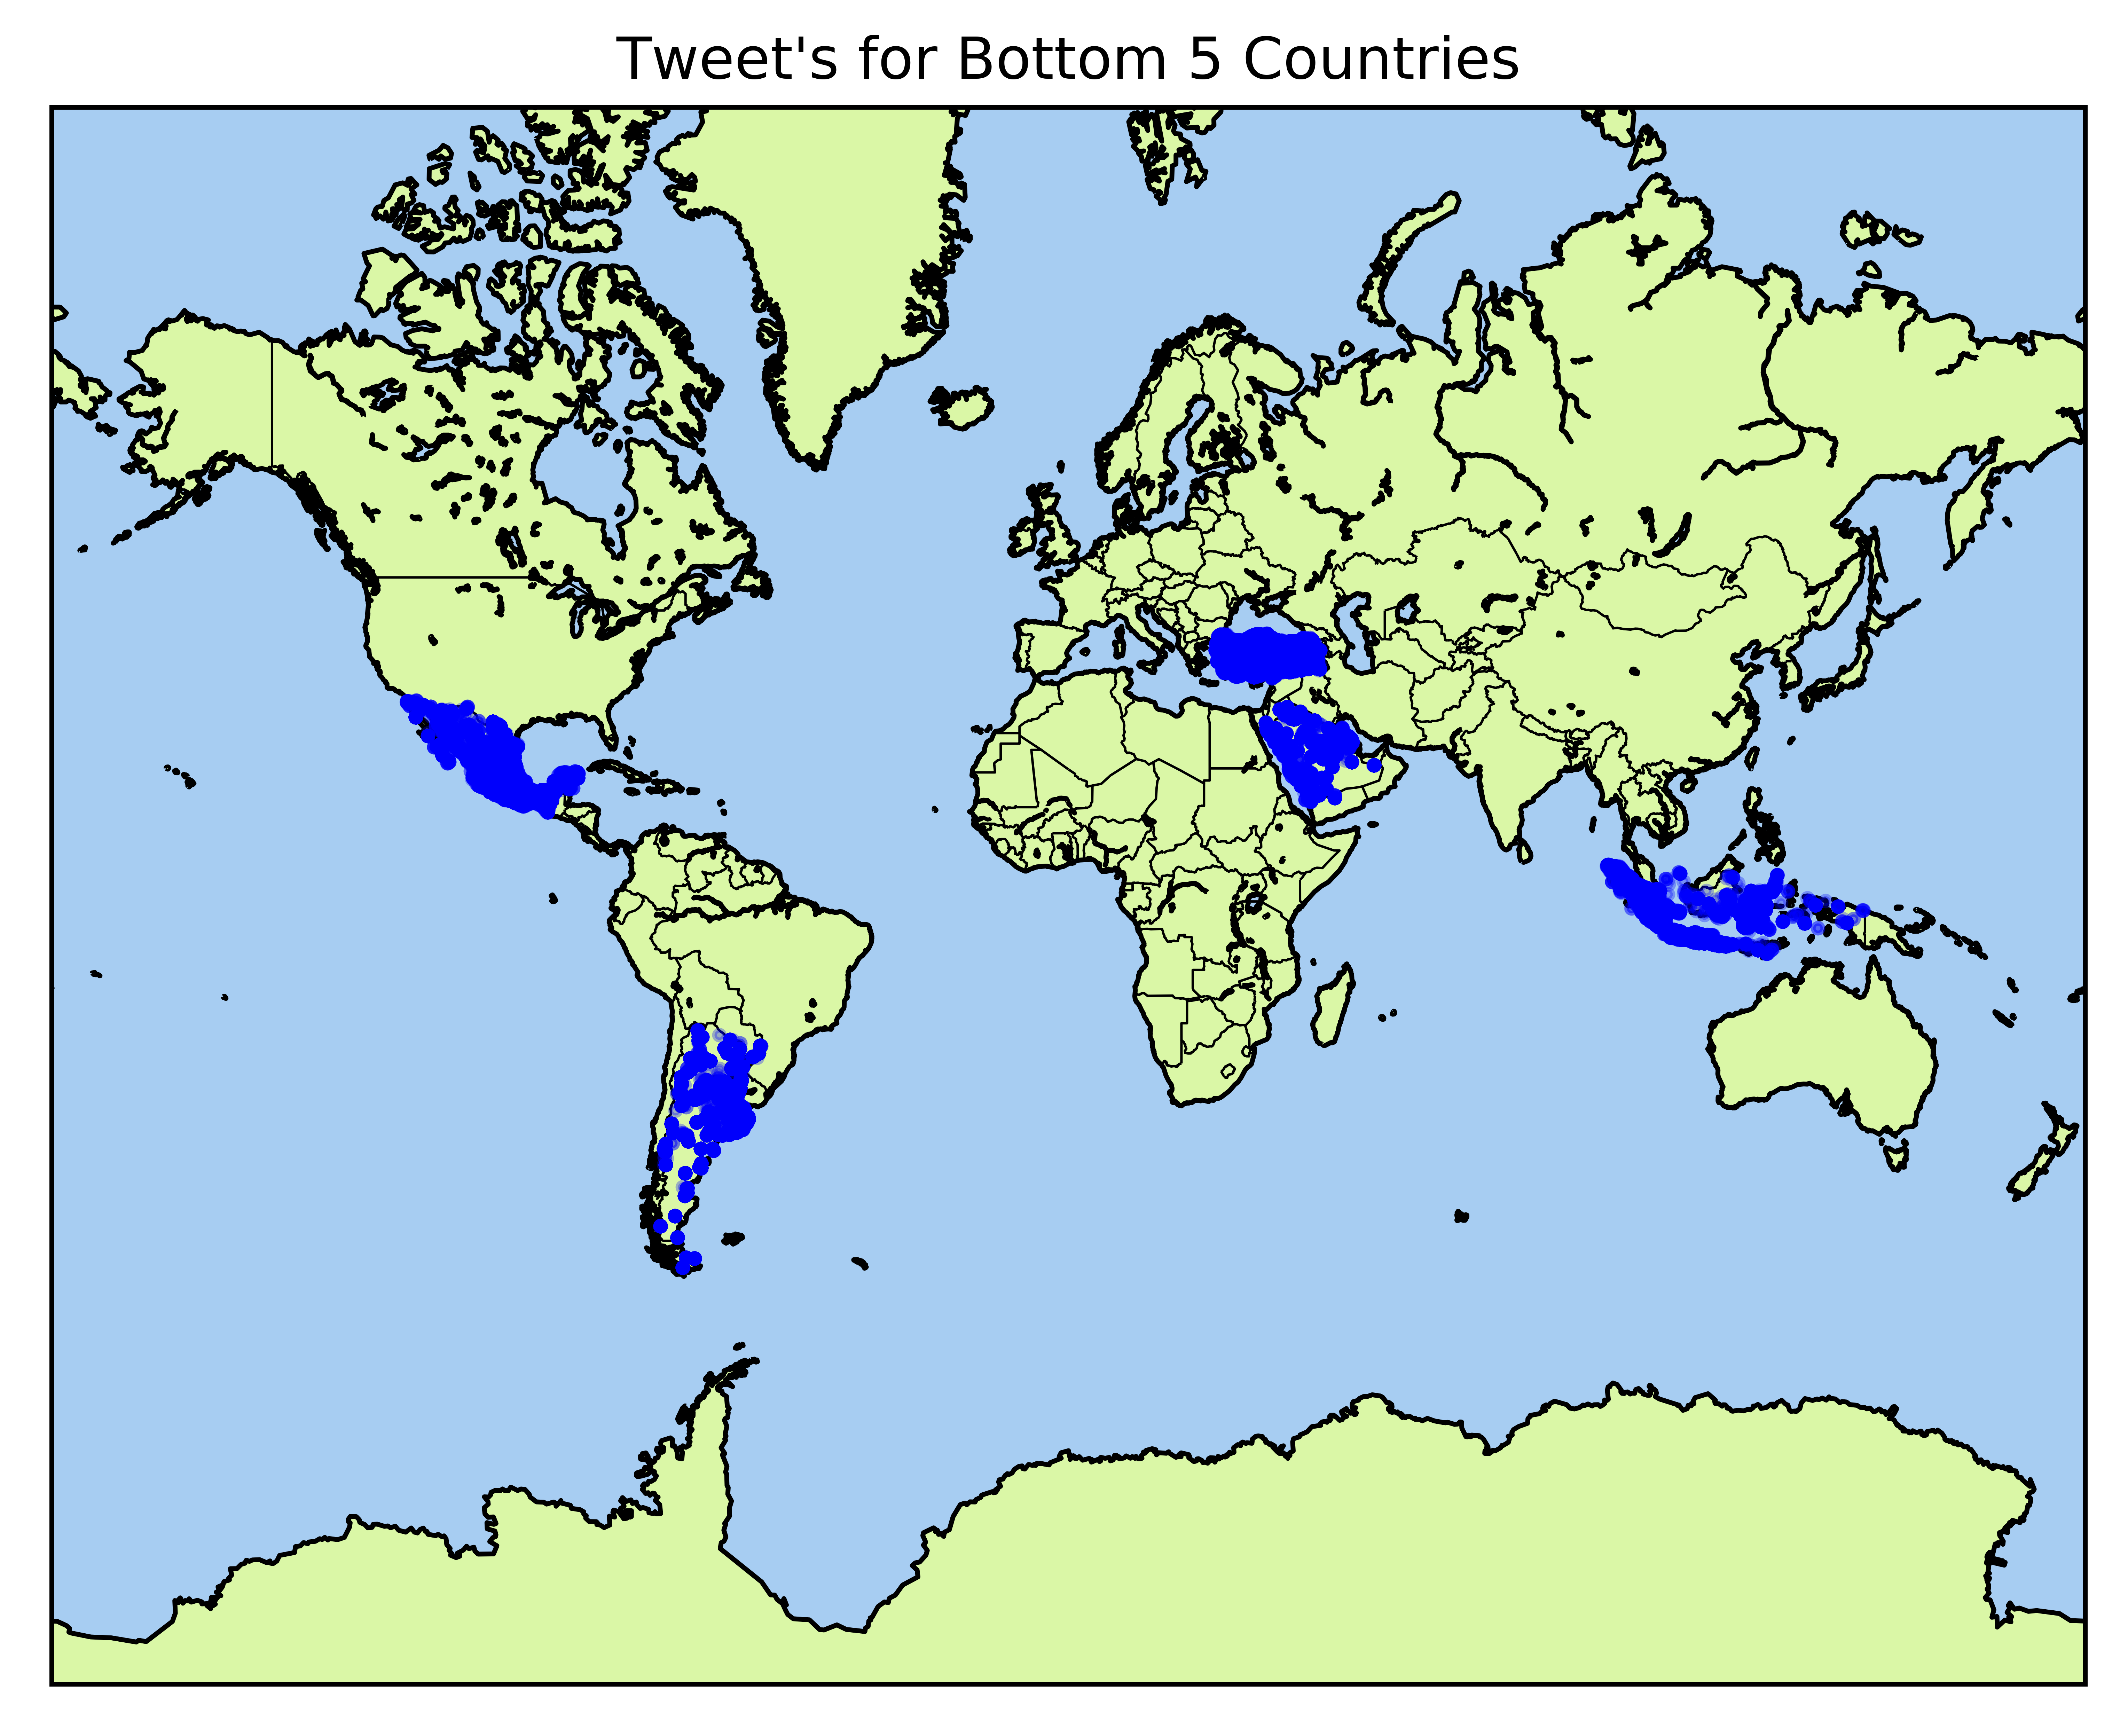

In [4]:
# Address KeyError: 'PROJ_LIB'
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# import package
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

#map size
plt.figure(figsize=(12,6), dpi=1000)

# Declare map projection, size and resolution
map = Basemap(projection='merc',
              llcrnrlat=-80,
              urcrnrlat=80,
              llcrnrlon=-180,
              urcrnrlon=180,
              lat_ts=20,
              resolution='l')

# set lon and lat   
lon = list(df['centroid'].str[1])
lat = list(df['centroid'].str[0])
    
x,y = map(lon,lat)

# plot map
map.plot(x, y, 'bo', markersize=2, alpha=.3)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#DAF7A6', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

# set a title
plt.title("Tweet's for Bottom 5 Countries")

# Display map
plt.show()

## Data Cleaning

### Missing Data

A small percentage of tweets contained missing values for 'country_code.' When this occurred, or other missing data occurred, I chose to drop the entire row:

In [18]:
df['country_code'].dropna(axis=0, inplace=True)

### Delete Duplicate Users

During the 10 hours collection period many users tweeted more than once. To prevent potential leakage I deleted the duplicate tweets by user ('screen_name').



In [5]:
df = df.drop_duplicates(subset = ["screen_name"])

In [6]:
len(df)

158452

Now we get 360750 of 1182355 records which are prepared for our analysis.

TR    41503

ID    38425

MX    27073

AR    26432

SA    25019

### Image URL

I am going to remove the `_normal` character at the end of the URL. This is the [method](https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-column-of-a-pandas-dataframe).

In [7]:
df['image_url'] = df['image_url'].str.replace('_normal','')

In [9]:
df.to_csv(r'final3.csv',index = False,header = True)

In [10]:
import pandas as pd

# 'utf-8' ensures that emojis are preserved 

df0 = pd.read_csv('final.csv', encoding='utf-8')
df1 = pd.read_csv('final1.csv', encoding='utf-8')
df2 = pd.read_csv('final2.csv', encoding='utf-8')
df3 = pd.read_csv('final3.csv', encoding='utf-8')

frames = [df0, df1, df2, df3]

result = pd.concat(frames)


In [11]:
result['country_code'].value_counts()

US    408476
BR    178279
JP    141651
TR    112296
ID    111506
GB    109742
AR     87524
IN     69866
MX     64271
SA     55074
Name: country_code, dtype: int64

In [12]:
df = result.drop_duplicates(subset = ["screen_name"])

In [13]:
df['country_code'].value_counts()

US    315517
BR    127002
JP     93233
GB     74490
TR     65107
ID     63820
IN     50602
AR     42121
MX     40844
SA     36601
Name: country_code, dtype: int64

In [14]:
final_df = df.groupby('country_code').head(36601)

In [15]:
final_df['country_code'].value_counts()

GB    36601
SA    36601
MX    36601
ID    36601
IN    36601
BR    36601
JP    36601
TR    36601
AR    36601
US    36601
Name: country_code, dtype: int64

In [20]:
E = {'US':'United States', 
     'BR': 'Brazil',
     'GB':'United Kingdom',
     'JP':'Japan', 
     'AR':'Argentina', 
     'TR': 'Turkey', 
     'MX':'Mexico', 
     'SA': 'Saudi Arabia', 
     'ID':'Indonesia',
     'IN':'India'}

final_df['country_name'] = final_df['country_code'].map(E)

/Users/guanghuamao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [21]:
final_df.to_csv(r'final_df.csv',index = False,header = True)

In [22]:
final_df1 = pd.read_csv('final_df.csv', encoding='utf-8')

In [23]:
E = {'US':'United States', 
     'BR': 'Brazil',
     'GB':'United Kingdom',
     'JP':'Japan', 
     'AR':'Argentina', 
     'TR': 'Turkey', 
     'MX':'Mexico', 
     'SA': 'Saudi Arabia', 
     'ID':'Indonesia',
     'IN':'India'}

final_df1['country_name'] = final_df1['country_code'].map(E)

In [26]:
final_df1['country_code'].value_counts()

GB    36601
SA    36601
MX    36601
ID    36601
IN    36601
BR    36601
JP    36601
TR    36601
AR    36601
US    36601
Name: country_code, dtype: int64

In [27]:
final_df1.to_csv(r'DAEN_Dataset.csv',index = False,header = True)

# Predictive Model

In [23]:
df

,tweet,country_code,bounding_box,screen_name,favourites_count,followers_count,statuses_count,friends_count,listed_count,image_url,banner_url,centroid
0,"Skin trial doang belagu sia,\nDah ah cape mo s...",ID,"[[[107.666224, -6.938641], [107.666224, -6.904...",bangsadpeople,3202,636,4754,442,1,https://pbs.twimg.com/profile_images/130582291...,https://pbs.twimg.com/profile_banners/10518289...,"(-6.921403, 107.67888099999999)"
1,@Pitty É como você já dizia na letra genial de...,BR,"[[[-48.285982, -16.052405], [-48.285982, -15.5...",HugsOfPoetry,9110,171,5648,597,0,https://pbs.twimg.com/profile_images/128967808...,https://pbs.twimg.com/profile_banners/10595783...,"(-15.776254, -47.796623000000004)"
2,@ruhsuzkarbonat Yapacak bişi yok...daha iyilerine,TR,"[[[28.632104, 40.802734], [28.632104, 41.23990...",papillonhero,1937,236,2555,601,0,https://pbs.twimg.com/profile_images/127750686...,https://pbs.twimg.com/profile_banners/78716328...,"(41.0213205, 29.005222500000002)"
3,"""Samay"" aur ""shabd"" dono ka upayog laparvahee ...",IN,"[[[86.054331, 19.850414], [86.054331, 19.90745...",abhi_kumar_pth,279,7,56,23,0,https://pbs.twimg.com/profile_images/125880954...,https://pbs.twimg.com/profile_banners/12575068...,"(19.878935, 86.08442550000001)"
4,ان الله لا يخيب عبدا تفائل به خيرا💙 https://t....,SA,"[[[46.304398, 24.332068], [46.304398, 25.11181...",M30000o,2,5337,696,218,3,https://pbs.twimg.com/profile_images/119581213...,https://pbs.twimg.com/profile_banners/11958119...,"(24.721943500000002, 46.685077)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1182331,"From #NitroBrewTaiwan\n""We went glass shopping...",US,"[[[-111.972849, 33.203761], [-111.972849, 33.3...",NitroBrew,1643,603,2458,1656,36,https://pbs.twimg.com/profile_images/111420868...,https://pbs.twimg.com/profile_banners/23432106...,"(33.282450499999996, -111.8808735)"
1182334,@wargalokall @JatimFess Ngamar dan ngamer,ID,"[[[112.767207, -7.623788], [112.767207, -7.553...",anaswahyudii,1336,284,4828,235,1,https://pbs.twimg.com/profile_images/130806224...,https://pbs.twimg.com/profile_banners/78399335...,"(-7.588865, 112.8170635)"
1182345,@anakketujuh_ Pantes gw Tanya bekasi Ada apa? ...,ID,"[[[109.190446, -7.704103], [109.190446, -7.645...",selingkuhhanmu,8266,168,1690,102,0,https://pbs.twimg.com/profile_images/130435385...,https://pbs.twimg.com/profile_banners/80631141...,"(-7.6749275, 109.26433349999999)"
1182347,It's all about last night rain...@mybmc \nThi...,IN,"[[[72.74484, 18.845343], [72.74484, 19.502937]...",Kalpeshvporwal1,4884,722,2169,2381,2,https://pbs.twimg.com/profile_images/130437679...,https://pbs.twimg.com/profile_banners/12475314...,"(19.17414, 72.874244)"
